In [1]:
import os
import sqlalchemy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import credentials

In [2]:
DB_USER = credentials.username()
DB_PASSWORD = credentials.password()
DB_SERVER = "mydbinstance.cmgiyjltohsu.us-east-1.rds.amazonaws.com"
DATABASEURI = "postgresql://"+DB_USER+":"+DB_PASSWORD+"@"+DB_SERVER+"/FakeTasticdb"

# Connect sql engine
engine = sqlalchemy.create_engine(DATABASEURI)

### List of features:

Non text:

* hashtag
* retweet count
* retweet (yes/no)
* retweet_count
* user_verified
* user_followers_count
* user_statuses_count
* user_friends_count
* user_favorites_count
* tweet_relative_age

Text:

* length
* % capitalized
* links
* bad words
* punctuation (!,?)
* hashtags

In [86]:
#conn = engine.connect()
query = """SELECT tweet_id, tweet_hashtag, retweet, retweet_count, tweet_text,
                user_verified, user_followers_count, 
                user_statuses_count, user_friends_count,
                user_favourites_count, tweet_relative_age, is_fake
           FROM  tweets_detailed limit 50000
           """
#alltweets = conn.execute(text(query))
#conn.close()

In [87]:
tweets = pd.read_sql_query(query, engine)

In [88]:
tweets.head()

,tweet_id,tweet_hashtag,retweet,retweet_count,tweet_text,user_verified,user_followers_count,user_statuses_count,user_friends_count,user_favourites_count,tweet_relative_age,is_fake
0,544347456238931968,sydneysiege,False,0,@Uber_Sydney @mtats Thank you!,False,1295,7015,2001,43,5,True
1,544302519191863296,sydneysiege,False,0,@braduok there's 1-2 men holding 13 people hos...,False,5348,50787,2026,9176,10,True
2,544319371292983297,sydneysiege,False,0,@calsdiscostick they said it connects to the I...,False,390,2112,942,1205,3,True
3,544276351952244737,sydneysiege,False,1,@Luke_rative @australian true that but without...,False,59,999,214,663,10,True
4,544319916212367360,sydneysiege,False,0,@DeAnnaSabaoth Hope it helps :) have a good da...,False,556,12421,145,480,11,True


In [6]:
len(tweets[tweets['is_fake']==True]) / len(tweets)

0.38714

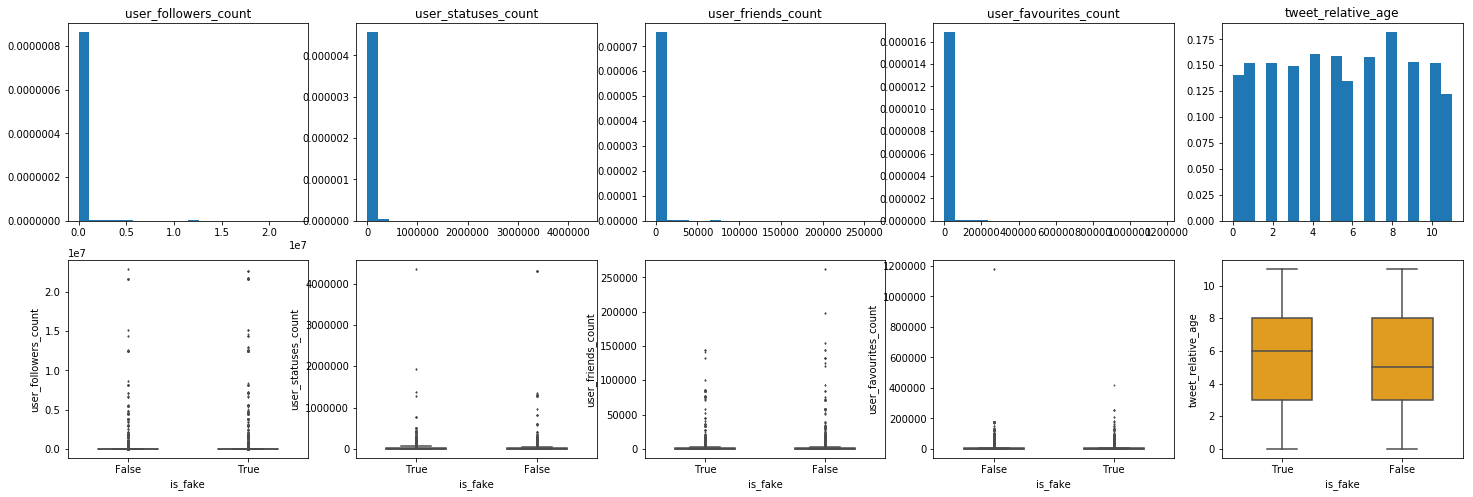

In [7]:
target_name = 'is_fake'
continuous_vars = ['user_followers_count', 'user_statuses_count', 'user_friends_count','user_favourites_count','tweet_relative_age']
fig, ax = plt.subplots(2,5,figsize=(25,8))
for i, var in enumerate(continuous_vars):
    aux = pd.DataFrame({var: tweets[var],
              target_name: tweets[target_name]})
    ax[0, i].hist(tweets[var], bins=20, density=True)
    ax[0, i].set_title(var)
    meds = aux.groupby(target_name).median().sort_values(var, ascending=False).index
    sns.boxplot(x=target_name, y=var, 
                data=aux, 
                order=meds,
                width=0.5,
                ax=ax[1,i],
                fliersize=1,
                color='orange')

## Baseline Model without text

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import (roc_curve, precision_recall_curve,
                             recall_score, make_scorer)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [9]:
# Split data train / test
X = tweets[[x for x in tweets.columns if x not in ['tweet_id', 'is_fake', 'tweet_text']]]
y = tweets['is_fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Logistic Regression

In [10]:
scoring = {'roc_auc': 'roc_auc', 
           'average_precision': 'average_precision',
           'macro_average_recall': make_scorer(recall_score, average='binary')}

grid_param = [{'logisticregression__penalty': ['l1', 'l2'],
               'logisticregression__C': np.logspace(-3, 3, 13)}]
pipe = make_pipeline(MinMaxScaler(), LogisticRegression())
grid_logistic = GridSearchCV(pipe, grid_param, cv=5, verbose=0,
                             scoring=scoring, refit='roc_auc',
                             n_jobs=-1, return_train_score=True)
grid_logistic.fit(X_train, y_train)
results_logistic = grid_logistic.cv_results_
grid_logistic.best_params_

/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'logisticregression__C': 1000.0, 'logisticregression__penalty': 'l1'}

In [11]:
results_logistic_df = pd.DataFrame()
results_logistic_df['penalty'] = results_logistic['param_logisticregression__penalty'].data
results_logistic_df['C']  = results_logistic['param_logisticregression__C'].data
results_logistic_df['macro_average_recall']  = results_logistic['mean_test_macro_average_recall']
results_logistic_df['roc_auc'] = results_logistic['mean_test_roc_auc']
results_logistic_df['average_precision'] = results_logistic['mean_test_average_precision']
results_logistic_df.sort_values(by='roc_auc', ascending=False).head()

,penalty,C,macro_average_recall,roc_auc,average_precision
24,l1,1000,0.058613,0.530729,0.426999
22,l1,316.228,0.058613,0.530722,0.426986
25,l2,1000,0.058613,0.530714,0.426944
20,l1,100,0.058613,0.530709,0.426961
23,l2,316.228,0.058613,0.530684,0.426929


In [12]:
grid_logistic.score(X_test, y_test)

0.5250684970383145

### Random Forest

In [13]:
grid_param = {'randomforestclassifier__max_leaf_nodes':range(5, 50)}
pipe = make_pipeline(RandomForestClassifier(warm_start=True, random_state=0))
grid_rf = GridSearchCV(pipe, grid_param, cv=5, verbose=0,
                             n_jobs=-1, return_train_score=True,
                             scoring=scoring,
                             refit='roc_auc'
                            )
grid_rf.fit(X_train, y_train)
results_rf = grid_rf.cv_results_
grid_rf.best_params_

/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'randomforestclassifier__max_leaf_nodes': 49}

In [14]:
grid_rf.score(X_test, y_test)

0.6675498632864831

## Using text data

### Baseline

In [17]:
# Split data train / test
X = tweets['tweet_text']
y = tweets['is_fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
print("Number of train tweets", len(X_train))
print("Number of test tweets",len(X_test))

# check balances
print("% of class 1 train", len(y_train[y_train == 1]) / len(y_train))
print("% of class 1 test", len(y_test[y_test == 1]) / len(y_test))

Number of train tweets 37500
Number of test tweets 12500
% of class 1 train 0.3871733333333333
% of class 1 test 0.38704


In [18]:
np.random.seed(2019)
param_grid_baseline = {"logisticregression__C": np.logspace(-1,1,3)}
pipe_baseline = make_pipeline(CountVectorizer(),
                              LogisticRegression(solver='liblinear'))
grid_baseline = GridSearchCV(pipe_baseline,
                             param_grid=param_grid_baseline,
                             cv=5, scoring="roc_auc")
grid_baseline.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': array([ 0.1,  1. , 10. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [19]:
grid_baseline.best_params_

{'logisticregression__C': 10.0}

In [20]:
np.mean(grid_baseline.cv_results_['mean_test_score'])

0.9654684465626349

In [21]:
grid_baseline.score(X_test, y_test)

0.9868683211273668

In [22]:
def plot_coefficients(coefs, features):
    fig,ax = plt.subplots(figsize=(17,7))
    
    coefs = pd.DataFrame(coefs, columns=['coef']).reset_index()
    coefs['abs_coef'] = abs(coefs['coef'])
    coefs['sign'] = coefs['coef'].map(np.sign)
    coefs['features'] = coefs['index'].apply(lambda x: features[x])
    top_coefs = coefs.sort_values(by='abs_coef', ascending=False).head(50)
    top_coefs = top_coefs.sort_values(by='coef', ascending=False)
    top_coefs.sort_values(by='coef', ascending=False).plot(kind='bar', 
                y='coef', x='features',
                ax=ax,
                rot=40,
                legend=False,
                sort_columns=True,
                title='Top 20 features for Logistic Regression',
                color=np.where(top_coefs["coef"]> 0, 'b', 'g'))
    labels = [l.get_text() for l in ax.get_xticklabels()]
    ax = ax.set_xticklabels(labels, ha='right')
    plt.show()

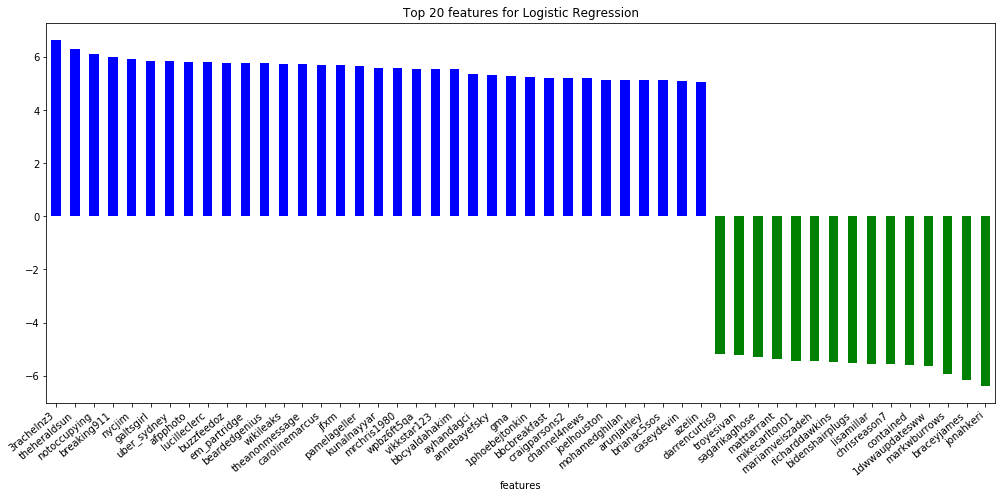

In [23]:
voc_word_baseline = grid_baseline.best_estimator_. \
                        named_steps['countvectorizer'].vocabulary_
voc_index_baseline = {y:x for x,y in voc_word_baseline.items()}
# Coefficientes
coefs_baseline = grid_baseline.best_estimator_.named_steps['logisticregression'].coef_[0]
plot_coefficients(coefs_baseline, voc_index_baseline)

### Normalizer

In [24]:
np.random.seed(2019)
param_grid_normalizer = {"logisticregression__C": np.logspace(-1,1,3),
                         "normalizer": [None, Normalizer()]}
pipe_normalizer = make_pipeline(CountVectorizer(),
                                Normalizer(),
                                LogisticRegression(solver='liblinear'))
grid_normalizer = GridSearchCV(pipe_normalizer,
                               param_grid=param_grid_normalizer,
                               cv=5, scoring="roc_auc")
grid_normalizer.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': array([ 0.1,  1. , 10. ]), 'normalizer': [None, Normalizer(copy=True, norm='l2')]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [25]:
grid_normalizer.best_params_

{'logisticregression__C': 10.0, 'normalizer': None}

In [26]:
grid_normalizer.score(X_test, y_test)

0.9868683211273668

In [27]:
np.mean(grid_normalizer.cv_results_['mean_test_score'])

0.941761712005135

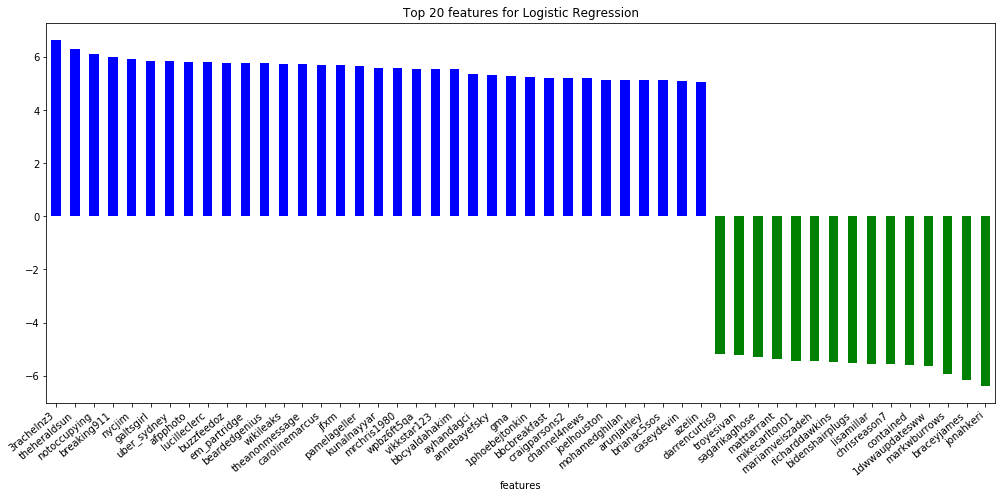

In [28]:
voc_word_normalizer = grid_normalizer.best_estimator_. \
                named_steps['countvectorizer'].vocabulary_
voc_index_normalizer = {y:x for x,y in voc_word_normalizer.items()}
# Coefficientes
coefs_normalizer = grid_normalizer.best_estimator_. \
                        named_steps['logisticregression'].coef_[0]
plot_coefficients(coefs_normalizer, voc_index_normalizer)

### Char

In [29]:
np.random.seed(2019)
param_grid_char = {"logisticregression__C": [10],#np.logspace(-1,1,3),
                   "normalizer": [None, Normalizer()],
                   "countvectorizer__ngram_range": [(2, 4), (3, 6)]}
pipe_char = make_pipeline(CountVectorizer(analyzer="char_wb", min_df=4),
                          Normalizer(),
                          TfidfTransformer(),
                          LogisticRegression(solver='liblinear'))
grid_char = GridSearchCV(pipe_char, param_grid=param_grid_char, cv=5, scoring="roc_auc")
grid_char.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=4,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': [10], 'normalizer': [None, Normalizer(copy=True, norm='l2')], 'countvectorizer__ngram_range': [(2, 4), (3, 6)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [30]:
np.mean(grid_char.cv_results_['mean_test_score'])

0.976384738510051

In [31]:
grid_char.score(X_test, y_test)

0.9848476706366946

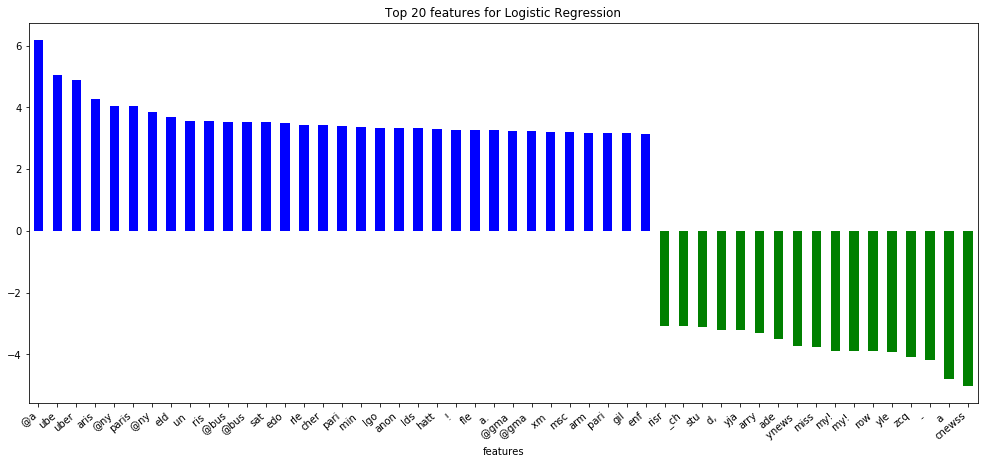

In [33]:
voc_word_char = grid_char.best_estimator_. \
                    named_steps['countvectorizer'].vocabulary_
voc_index_char = {y:x for x,y in voc_word_char.items()}
# Coefficientes
coefs_char = grid_char.best_estimator_.named_steps['logisticregression'].coef_[0]
plot_coefficients(coefs_char, voc_index_char)

## Adding text features

In [57]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def num_hashtags(body):
    r = re.findall(r"(?=(# ))", body)
    return len(r)

def num_tags(body):
    r = re.findall(r"(?=(@ ))", body)
    return len(r)

def get_num_sentences(body):
    return len(sent_tokenize(body))
    
def find_html(body):
    string_lst = ['https://', 'www.', 'http://', 'html']
    r = re.findall(r"(?=("+'|'.join(string_lst)+r"))", body)
    if len(r) > 0:
        return 1
    else:
        return 0

def percentage_capital(body):
    cap = sum(1 for c in body if c.isupper())
    return cap/ sum(1 for c in test if c.isalpha())
    

def num_exclamation(body):
    r = re.findall(r"(?=(!))", body)
    return len(r)

def more_than_three(body):
    r = re.findall(r'((\w)\2{3,})', body)
    if len(r) > 0:
        return 1
    else:
        return 0

def num_questions(body):
    r = re.findall(r"(?=(\? ))", body)
    return len(r)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreanavarrete/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [63]:
X_train.head()

39758    @DAJSamarasinghe @FamousRob @nicchristensen Ye...
18457    @dougom Conservatives are profoundly sick of R...
33239    @ramblesofpower It's not "islamophobia" it's "...
35006    @KyaYaarKuchBi @MariamVeiszadeh \nI am sorry, ...
30982    @DailyMailAU @joeleigh41 \n the BBC translated...
Name: tweet_text, dtype: object

In [93]:
# Length
tweets['tweet_length'] = tweets['tweet_text'].map(len)
# Number of sentences
tweets['num_sentences'] =  tweets['tweet_text'].map(get_num_sentences)
# Number of hastags
tweets['num_hashtags'] = tweets['tweet_text'].map(num_hashtags)
# Number of taggs
tweets['num_tags'] = tweets['tweet_text'].map(num_tags)
# find_html
tweets['with_html'] = tweets['tweet_text'].map(find_html)
# Percentage Capitalize
tweets['percentage_capital'] = tweets['tweet_text'].map(percentage_capital)
# Number of excalamation marks
tweets['num_exclamation'] = tweets['tweet_text'].map(num_exclamation)
# Num questions
tweets['num_questions'] = tweets['tweet_text'].map(num_questions)

In [69]:
# Features
text_features = ['tweet_text', 'tweet_length', 'num_sentences', 
                 'num_hashtags', 'num_tags', 'with_html',
                 'percentage_capital', 'num_exclamation', 'num_questions']

# Split data train / test
X = tweets[text_features]
y = tweets['is_fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
print("Number of train tweets", len(X_train))
print("Number of test tweets",len(X_test))

# check balances
print("% of class 1 train", len(y_train[y_train == 1]) / len(y_train))
print("% of class 1 test", len(y_test[y_test == 1]) / len(y_test))

Number of train tweets 37500
Number of test tweets 12500
% of class 1 train 0.3871733333333333
% of class 1 test 0.38704


In [71]:
np.random.seed(2019)
param_grid_features = {"clf__C": np.logspace(-1,1,3),
                       "pre__tfidfvectorizer__ngram_range": [(2, 4), (3, 6)]}
pipe_vec = make_pipeline(TfidfVectorizer())

preprocess = make_column_transformer(
            (TfidfVectorizer(analyzer="char_wb", min_df=4), 'tweet_text'),
                                     remainder='passthrough')
pipe_features = Pipeline([('pre', preprocess),
                 ('clf', LogisticRegression(solver='liblinear'))])
grid_features = GridSearchCV(pipe_features, 
                             param_grid=param_grid_features, 
                             cv=5, scoring="roc_auc")
grid_features.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pre', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('tfidfvectorizer', TfidfVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8',...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf__C': array([ 0.1,  1. , 10. ]), 'pre__tfidfvectorizer__ngram_range': [(2, 4), (3, 6)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [72]:
grid_features.best_params_

{'clf__C': 10.0, 'pre__tfidfvectorizer__ngram_range': (3, 6)}

In [73]:
np.mean(grid_features.cv_results_['mean_test_score'])

0.9402093490299347

In [75]:
grid_features.score(X_test, y_test)

0.9846527895352085

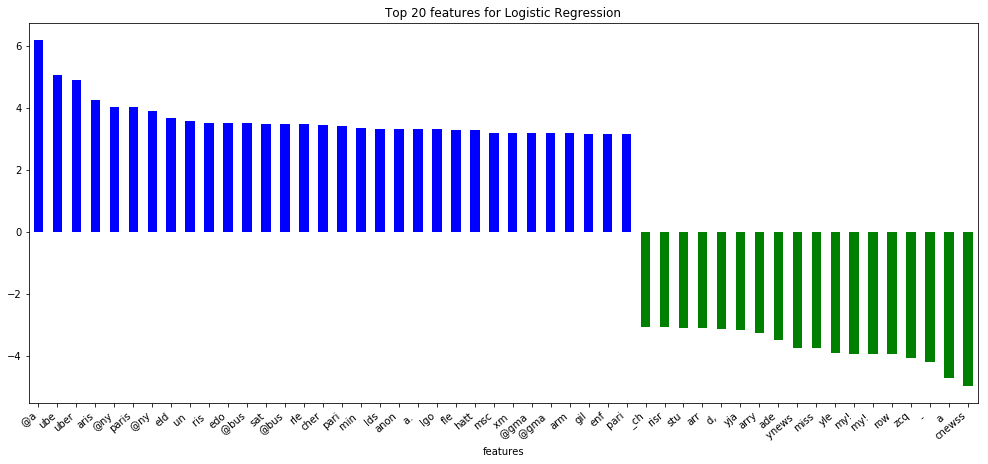

In [76]:
voc_char_features = grid_features.best_estimator_.named_steps['pre']. \
                        named_transformers_['tfidfvectorizer'].vocabulary_.copy()
extra_features = {x:i+len(voc_char_features) 
                  for i,x in enumerate([x for x in text_features if x!= 'tweet_text'])}
voc_char_features.update(extra_features)
voc_index_features = {y:x for x,y in voc_char_features.items()}
# Coefficientes
coefs_features = grid_features.best_estimator_.named_steps['clf'].coef_[0]
plot_coefficients(coefs_features, voc_index_features)

In [81]:
list(range(5, 50, 10))

[5, 15, 25, 35, 45]

In [82]:
np.random.seed(2019)
param_grid_features = {'clf__max_leaf_nodes':range(5, 50, 10),
                       "pre__tfidfvectorizer__ngram_range": [(2, 4), (3, 6)]}

preprocess = make_column_transformer(
            (TfidfVectorizer(analyzer="char_wb", min_df=4), 'tweet_text'),
                                     remainder='passthrough')
pipe_features = Pipeline([('pre', preprocess),
                 ('clf', RandomForestClassifier(warm_start=True, random_state=0))])
grid_features = GridSearchCV(pipe_features, 
                             param_grid=param_grid_features, 
                             cv=5, scoring="roc_auc")
grid_features.fit(X_train, y_train)

/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pre', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('tfidfvectorizer', TfidfVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8',...tors='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf__max_leaf_nodes': range(5, 50, 10), 'pre__tfidfvectorizer__ngram_range': [(2, 4), (3, 6)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [83]:
grid_features.best_params_

{'clf__max_leaf_nodes': 45, 'pre__tfidfvectorizer__ngram_range': (3, 6)}

In [84]:
np.mean(grid_features.cv_results_['mean_test_score'])

0.7678059511679496

In [85]:
grid_features.score(X_test, y_test)

0.8186840286736354

## All Features

In [94]:
text_features = ['tweet_text', 'tweet_length', 'num_sentences', 
                 'num_hashtags', 'num_tags', 'with_html',
                 'percentage_capital', 'num_exclamation', 'num_questions']

tweet_features = ['tweet_hashtag', 'retweet', 'retweet_count',
                  'user_verified', 'user_followers_count', 
                  'user_statuses_count', 'user_friends_count',
                  'user_favourites_count', 'tweet_relative_age']

all_features = text_features + tweet_features
# Split data train / test
X = tweets[all_features]
y = tweets['is_fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
print("Number of train tweets", len(X_train))
print("Number of test tweets",len(X_test))

# check balances
print("% of class 1 train", len(y_train[y_train == 1]) / len(y_train))
print("% of class 1 test", len(y_test[y_test == 1]) / len(y_test))

Number of train tweets 37500
Number of test tweets 12500
% of class 1 train 0.3871733333333333
% of class 1 test 0.38704


In [97]:
X_train.head()

,tweet_text,tweet_length,num_sentences,num_hashtags,num_tags,with_html,percentage_capital,num_exclamation,num_questions,tweet_hashtag,retweet,retweet_count,user_verified,user_followers_count,user_statuses_count,user_friends_count,user_favourites_count,tweet_relative_age
39758,@DAJSamarasinghe @FamousRob @nicchristensen Ye...,81,2,0,0,0,0.142857,0,0,sydneysiege,False,1,False,792,23494,1055,1239,1
18457,@dougom Conservatives are profoundly sick of R...,77,1,0,0,0,0.031746,0,0,sydneysiege,False,0,False,16019,251219,2656,84337,11
33239,"@ramblesofpower It's not ""islamophobia"" it's ""...",126,2,0,0,0,0.031746,0,0,sydneysiege,False,1,False,3157,19659,2995,8230,11
35006,"@KyaYaarKuchBi @MariamVeiszadeh \nI am sorry, ...",127,1,0,0,0,0.126984,0,0,sydneysiege,False,1,False,192,6652,479,122,5
30982,@DailyMailAU @joeleigh41 \n the BBC translated...,118,2,0,0,0,0.317460,1,0,sydneysiege,False,0,False,1588,55787,1818,34,0


In [101]:
np.random.seed(2019)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
param_grid_features = {"clf__C": [10], #np.logspace(-1,1,3),
                       "pre__tfidfvectorizer__ngram_range": [(2, 4), (3, 6)]}
pipe_vec = make_pipeline(TfidfVectorizer())

preprocess = make_column_transformer(
            (TfidfVectorizer(analyzer="char_wb", min_df=4), 'tweet_text'),
            (StandardScaler(), numeric_cols),
            (OneHotEncoder(handle_unknown='ignore'), ['tweet_hashtag']),
                                     remainder='passthrough')
pipe_features = Pipeline([('pre', preprocess),
                 ('clf', LogisticRegression(solver='liblinear'))])
grid_features = GridSearchCV(pipe_features, 
                             param_grid=param_grid_features, 
                             cv=5, scoring="roc_auc")
grid_features.fit(X_train, y_train)

/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/andreanavarrete/

/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/andreanavarrete/.pyenv/version

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pre', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('tfidfvectorizer', TfidfVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8',...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf__C': [10], 'pre__tfidfvectorizer__ngram_range': [(2, 4), (3, 6)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [102]:
grid_features.best_params_

{'clf__C': 10, 'pre__tfidfvectorizer__ngram_range': (3, 6)}

In [103]:
np.mean(grid_features.cv_results_['mean_test_score'])

0.9697471331269765

In [104]:
grid_features.score(X_test, y_test)

/Users/andreanavarrete/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


0.9743199097374619

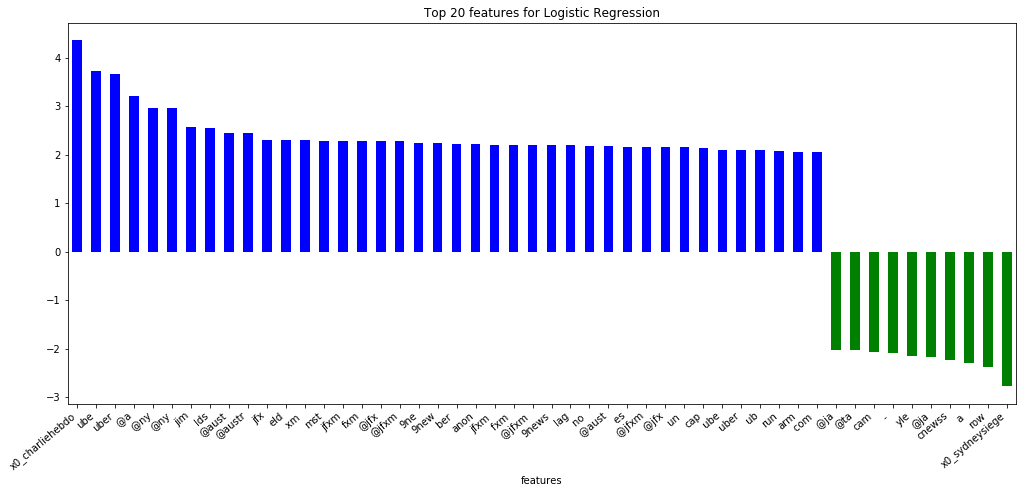

In [128]:
voc_char_features = grid_features.best_estimator_.named_steps['pre']. \
                        named_transformers_['tfidfvectorizer'].vocabulary_.copy()
numeric_features = {x:i+len(voc_char_features) 
                  for i,x in enumerate(numeric_cols)}
voc_char_features.update(numeric_features)

onehot = list(grid_features.best_estimator_.named_steps['pre']. \
                named_transformers_['onehotencoder'].get_feature_names())
onehot_features = {x:i+len(voc_char_features) 
                  for i,x in enumerate(onehot)}
voc_char_features.update(onehot_features)

extra_features = {x:i+len(voc_char_features) 
                  for i,x in enumerate([x for x in all_features if x not in ['tweet_text', 'tweet_hashtag'] + numeric_cols])}
voc_char_features.update(extra_features)

voc_index_features = {y:x for x,y in voc_char_features.items()}
# Coefficientes
coefs_features = grid_features.best_estimator_.named_steps['clf'].coef_[0]
plot_coefficients(coefs_features, voc_index_features)